In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import glob
import datetime as dt
import multiprocessing as mp
from datetime import datetime
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas import Series
from tqdm import tqdm, tqdm_notebook
import time
import sys
import matplotlib.pyplot as plt




from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [ ]:
cd gdrive/My Drive/TFM/

/content/gdrive/My Drive/TFM


#Loading of already sampled DOLLAR BARS

In [ ]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
Dollar_bars = pd.DataFrame()
for i,file in enumerate(glob.glob("data/bars/new_features/*.csv")):
  if i == 0:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i, "files left", end='')
  else:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i, "files left",end='', flush=True)

Percentge of files already Loaded: 0.0 %. There are 1 files left

In [ ]:
Dollar_bars.drop(columns=['Unnamed: 0','timestamp.1'],inplace=True)
# timestamp parsing
Dollar_bars['timestamp'] = Dollar_bars.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%d %H:%M:%S.%f"))

Dollar_bars.index = Dollar_bars['timestamp']
Dollar_bars


#Method definition

##Multiprocessing

In [ ]:
class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

##Volatility and CUSUM filter

In [ ]:
#SNIPPET 3.1 DAILY VOLATILITY ESTIMATES

def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [ ]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [ ]:
# SNIPPET 3.4 ADDING A VERTICAL BARRIER

def add_vertical_barrier(t_events, close, num_days=10):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

In [ ]:
#SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD

def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

In [ ]:
# SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH

def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking percentage; 
                  element 1 is stop loss percentage.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events

In [ ]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

In [ ]:
# SNIPPET 3.5 LABELING FOR SIDE AND SIZE

def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

##PRIMARY MODEL AUX METHODS AND CLASSES

In [ ]:
# The function to add a certain number of columns
def adder(Data, times):
    
    for i in range(1, times + 1):
    
        z = np.zeros((len(Data), 1), dtype = float)
        Data = np.append(Data, z, axis = 1)        
    return Data
# The function to deleter a certain number of columns
def deleter(Data, index, times):
    
    for i in range(1, times + 1):
    
        Data = np.delete(Data, index, axis = 1)               
    
    return Data
# The function to delete a certain number of rows from the beginning
def jump(Data, jump):
    
    Data = Data[jump:, ]
    
    return Data

In [ ]:
def stochastic(Data, lookback, high, low, close, where, genre = 'High-Low'):
        
    # Adding a column
    Data = adder(Data, 1)
    
    if genre == 'High-Low':
        
        for i in range(len(Data)):
            
            try:
                Data[i, where] = (Data[i, close] - min(Data[i - lookback + 1:i + 1, low])) / (max(Data[i - lookback + 1:i + 1, high]) - min(Data[i - lookback + 1:i + 1, low]))
            
            except ValueError:
                pass
            
    if genre == 'Normalization':
        
        for i in range(len(Data)):
            
            try:
                Data[i, where] = (Data[i, close] - min(Data[i - lookback + 1:i + 1, close])) / (max(Data[i - lookback + 1:i + 1, close]) - min(Data[i - lookback + 1:i + 1, close]))
            
            except ValueError:
                pass
            
    Data[:, where] = Data[:, where] * 100  
    Data = jump(Data, lookback)
    return Data

##RETURNS AND MISC

In [ ]:
def returns(candles_close_prices):
    return pd.Series(np.diff(np.log(candles_close_prices)))

In [ ]:
def bar(xs, y): return np.int64(xs / y) * y

##training aux methods (train times and embargo period)

In [ ]:
def getTrainTimes(t1,testTimes):
  #Given testTimes, find the times of the training observations.
  #—t1.index: Time when the observation started.
  #—t1.value: Time when the observation ended.
  #—testTimes: Times of testing observations.
  trn=t1.copy(deep=True)
  for i,j in testTimes.iteritems():
    df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
    df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
    df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test 
    trn=trn.drop(df0.union(df1).union(df2))
  return trn
def getEmbargoTimes(times,pctEmbargo):
  # Get embargo time for each bar
  step=int(times.shape[0]*pctEmbargo)
  if step==0:
    mbrg=pd.Series(times,index=times)
  else:
    mbrg=pd.Series(times[step:],index=times[:-step])
    mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
  return mbrg


#PRIMARY MODEL

##MEAN REVERTING STRATEGY BASED ON STOCHASTIC INDICATOR

In [ ]:
# Indicator Parameters
lookback = 31
upper_barrier = 95
lower_barrier = 5
my_data = adder(Dollar_bars[["open", "high", "low", "close"]].to_numpy(), 10)
my_data = stochastic(my_data, lookback, 1, 2, 3, 4)

Dollar_bars['stochastic'] = np.append([np.nan]*31,my_data[:, 4])


In [ ]:
fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(
    x=Dollar_bars.index,
    y=Dollar_bars['stochastic'],
    name="Stochastic indicator",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )
fig.update_layout(
    legend=dict(
        x=0.0,
        y=0.98,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

In [ ]:
# compute sides
count_longs = np.zeros((len(Dollar_bars),1), dtype=bool)
count_shorts = np.zeros((len(Dollar_bars),1), dtype=bool)


aux = Dollar_bars['stochastic'][0]


for idx, val in enumerate(Dollar_bars['stochastic']):
  if val >= 5 and aux < 5:
    #print("place a long at index", idx)
    count_longs[idx] = True;
  if val <= 95 and aux > 95:
    #print("place a short at index", idx)
    count_shorts[idx] = True;
  aux = val


In [ ]:
# compute sides
Dollar_bars['side'] = np.nan

long_signals = Dollar_bars.loc[count_longs].index
short_signals = Dollar_bars.loc[count_shorts].index
Dollar_bars.loc[long_signals, 'side'] = 1
Dollar_bars.loc[short_signals, 'side'] = -1

print(Dollar_bars.side.value_counts())

# Remove Look ahead biase by lagging the signal
Dollar_bars['side'] = Dollar_bars['side'].shift(1)

# Drop the NaN values from our data set
Dollar_bars.dropna(axis=0, how='any', inplace=True)  

-1.0    1283
 1.0     817
Name: side, dtype: int64


#CUSUM FILTERING

In [ ]:
# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=Dollar_bars['close'], lookback=50)

Calculating daily volatility for dynamic thresholds


In [ ]:
aux = returns(Dollar_bars['close'])

Dollar_bars['return'] = np.append([np.nan],aux)

Dollar_bars.dropna(axis=0, how='any', inplace=True)  

Dollar_bars

,timestamp,open,high,low,close,grossValue,homeNotional,foreignNotional,tweet_count,tweet_count2,Google_trend1,Google_trend2,stochastic,side,return
timestamp,,,,,,,,,,,,,,,
2019-12-25 12:15:27.184,2019-12-25 12:15:27.184,125.00,125.35,123.55,124.10,132734923715,76878.119669,9.565672e+06,647.0,247.0,57.0,57.0,7.818930,1.0,-0.010820
2019-12-26 19:55:33.954,2019-12-26 19:55:33.954,128.00,129.55,127.25,127.70,131549206470,74482.523486,9.556294e+06,643.0,307.0,67.0,73.0,49.726776,-1.0,0.028596
2019-12-29 13:51:24.670,2019-12-29 13:51:24.670,130.70,131.90,130.40,130.65,129772386575,73081.358837,9.581556e+06,735.0,337.0,74.0,65.0,87.113402,-1.0,0.022838
2019-12-29 17:29:42.425,2019-12-29 17:29:42.425,132.55,134.15,132.50,133.60,128903662010,71459.559025,9.535651e+06,499.0,306.0,69.0,69.0,95.397490,-1.0,0.022328
2019-12-29 20:30:40.928,2019-12-29 20:30:40.928,136.20,136.25,134.20,134.70,129772864095,71067.812296,9.612632e+06,605.0,300.0,79.0,85.0,75.342466,-1.0,0.008200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 13:00:48.347,2021-05-23 13:00:48.347,1943.05,1953.25,1883.80,1905.90,28433571110,5006.370556,9.563167e+06,6442.0,3193.0,98.0,46.0,4.347826,1.0,-0.006902
2021-05-23 13:09:59.114,2021-05-23 13:09:59.114,1935.35,1971.25,1903.50,1968.15,28265549090,4867.099049,9.479227e+06,6442.0,3193.0,98.0,46.0,17.559495,1.0,0.032140
2021-05-23 16:21:04.716,2021-05-23 16:21:04.716,1841.70,1844.70,1785.00,1793.50,29885841095,5286.206886,9.564140e+06,6735.0,5436.0,100.0,51.0,2.117061,1.0,-0.092925


In [ ]:
close = Dollar_bars['close']

# creating our event triggers using the CUSUM filter 
cusum_events = get_t_events(Dollar_bars['close'], threshold=daily_vol.mean())

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=0.5)

# determining timestamps of first touch   

pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.005 # setting a minimum return of 0.5% 

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=Dollar_bars['side']
                                   )

Applying Symmetric CUSUM filter.


100%|██████████| 2097/2097 [00:00<00:00, 19904.94it/s]
2021-12-14 10:44:13.623479 100.0% apply_pt_sl_on_t1 done after 0.01 minutes. Remaining 0.0 minutes.


In [ ]:
triple_barrier_events

,t1,trgt,side
2020-01-05 02:21:43.122,2020-01-05 15:43:01.955,0.032676,-1.0
2020-01-08 01:04:07.761,2020-01-08 20:19:09.519,0.028223,-1.0
2020-01-14 04:04:19.490,2020-01-14 17:08:04.253,0.031907,-1.0
2020-01-14 17:49:57.387,2020-01-17 05:43:28.504,0.047432,-1.0
2020-01-18 14:19:57.552,2020-01-19 11:06:40.348,0.056503,-1.0
...,...,...,...
2021-05-21 19:50:46.707,2021-05-23 05:34:56.725,0.181426,1.0
2021-05-23 09:14:16.219,2021-05-23 21:28:13.407,0.168070,1.0
2021-05-23 12:45:52.898,NaT,0.165393,1.0
2021-05-23 16:21:04.716,2021-05-23 21:28:13.407,0.158479,1.0


In [ ]:
labels = get_bins(triple_barrier_events, Dollar_bars['close'])
labels.side.value_counts()  

-1.0    183
 1.0    135
Name: side, dtype: int64

In [ ]:
labels

,ret,trgt,bin,side
2020-01-05 02:21:43.122,-0.008385,0.032676,0,-1.0
2020-01-08 01:04:07.761,0.049445,0.028223,1,-1.0
2020-01-14 04:04:19.490,-0.062382,0.031907,0,-1.0
2020-01-14 17:49:57.387,-0.035484,0.047432,0,-1.0
2020-01-18 14:19:57.552,0.079866,0.056503,1,-1.0
...,...,...,...,...
2021-05-21 01:48:26.038,0.112456,0.202989,0,-1.0
2021-05-21 08:15:37.398,-0.159263,0.200009,0,1.0
2021-05-21 19:50:46.707,-0.027175,0.181426,0,1.0
2021-05-23 09:14:16.219,0.000674,0.168070,0,1.0


In [ ]:
#CUMULATIVE SUM OF RETURNS
labels['ret'].cumsum()

2020-01-05 02:21:43.122   -0.008385
2020-01-08 01:04:07.761    0.041060
2020-01-14 04:04:19.490   -0.021323
2020-01-14 17:49:57.387   -0.056807
2020-01-18 14:19:57.552    0.023060
                             ...   
2021-05-21 01:48:26.038    1.094057
2021-05-21 08:15:37.398    0.934794
2021-05-21 19:50:46.707    0.907618
2021-05-23 09:14:16.219    0.908292
2021-05-23 16:21:04.716    1.068035
Name: ret, Length: 318, dtype: float64

In [ ]:
!pip install pyfolio
import pyfolio as pf
perf_func = pf.timeseries.perf_stats
perf_func(labels['ret'])

     |████████████████████████████████| 91 kB 4.4 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=9b7212b0cc625577bef4bd038b874852da25afcc6c221ce71084974948c22463
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39777 sha256=33948c29439aa43c442c351f2b17bed4f0e9cdd1998f4ee62da7c26e4ec81d03
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



Annual return          0.228202
Cumulative returns     0.296134
Annual volatility      1.120903
Sharpe ratio           0.755076
Calmar ratio           0.297650
Stability              0.095666
Max drawdown          -0.766678
Omega ratio            1.141959
Sortino ratio          1.079217
Skew                  -0.207900
Kurtosis               3.847231
Tail ratio             1.027449
Daily value at risk   -0.137862
dtype: float64

In [ ]:
triple_barrier_events

,t1,trgt,side
2020-01-05 02:21:43.122,2020-01-05 15:43:01.955,0.032676,-1.0
2020-01-08 01:04:07.761,2020-01-08 20:19:09.519,0.028223,-1.0
2020-01-14 04:04:19.490,2020-01-14 17:08:04.253,0.031907,-1.0
2020-01-14 17:49:57.387,2020-01-17 05:43:28.504,0.047432,-1.0
2020-01-18 14:19:57.552,2020-01-19 11:06:40.348,0.056503,-1.0
...,...,...,...
2021-05-21 19:50:46.707,2021-05-23 05:34:56.725,0.181426,1.0
2021-05-23 09:14:16.219,2021-05-23 21:28:13.407,0.168070,1.0
2021-05-23 12:45:52.898,NaT,0.165393,1.0
2021-05-23 16:21:04.716,2021-05-23 21:28:13.407,0.158479,1.0


In [ ]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       280
           1       0.12      1.00      0.21        38

    accuracy                           0.12       318
   macro avg       0.06      0.50      0.11       318
weighted avg       0.01      0.12      0.03       318

Confusion Matrix
[[  0 280]
 [  0  38]]

Accuracy
0.11949685534591195


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast

,bin
2020-01-05 02:21:43.122,0
2020-01-08 01:04:07.761,1
2020-01-14 04:04:19.490,0
2020-01-14 17:49:57.387,0
2020-01-18 14:19:57.552,1
...,...
2021-05-21 01:48:26.038,0
2021-05-21 08:15:37.398,0
2021-05-21 19:50:46.707,0
2021-05-23 09:14:16.219,0


In [ ]:
triple_barrier_events.loc[labels.index, :]

,t1,trgt,side
2020-01-05 02:21:43.122,2020-01-05 15:43:01.955,0.032676,-1.0
2020-01-08 01:04:07.761,2020-01-08 20:19:09.519,0.028223,-1.0
2020-01-14 04:04:19.490,2020-01-14 17:08:04.253,0.031907,-1.0
2020-01-14 17:49:57.387,2020-01-17 05:43:28.504,0.047432,-1.0
2020-01-18 14:19:57.552,2020-01-19 11:06:40.348,0.056503,-1.0
...,...,...,...
2021-05-21 01:48:26.038,2021-05-21 14:19:55.475,0.202989,-1.0
2021-05-21 08:15:37.398,2021-05-21 20:21:37.308,0.200009,1.0
2021-05-21 19:50:46.707,2021-05-23 05:34:56.725,0.181426,1.0
2021-05-23 09:14:16.219,2021-05-23 21:28:13.407,0.168070,1.0


In [ ]:
# Get features at event dates
X = Dollar_bars.loc[labels.index, :]

# Drop unwanted columns
X.drop([#'fracdiff', 
         'open', 'high', 'low', 'close','side','Google_trend1','grossValue','foreignNotional','timestamp','return'
         #,'avg','lower','upper'
         ], axis=1, inplace=True)

y = labels['bin']
X

2020-01-05 02:21:43.122    0
2020-01-08 01:04:07.761    1
2020-01-14 04:04:19.490    0
2020-01-14 17:49:57.387    0
2020-01-18 14:19:57.552    1
                          ..
2021-05-21 01:48:26.038    0
2021-05-21 08:15:37.398    0
2021-05-21 19:50:46.707    0
2021-05-23 09:14:16.219    0
2021-05-23 16:21:04.716    0
Name: bin, Length: 318, dtype: int64

#Training and results for secondary ensembled model for bollinger bands without features

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Setting random forest parameters

n_estimator = 1000
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=0)
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

In [ ]:
print('Training set contains:',len(X_train),'Testing set contains: ',len(X_test))

Training set contains: 254 Testing set contains:  64


In [ ]:
t1 = triple_barrier_events.loc[X_train.index, :]['t1']
testTimes = triple_barrier_events.loc[X_test.index, :]['t1']

len(getTrainTimes(t1,testTimes))

254

In [ ]:
testTimes = triple_barrier_events.loc[X_test.index, :]['t1']
testTimes


2021-04-13 15:19:53.380   2021-04-14 03:48:42.447
2021-04-14 21:52:23.484   2021-04-15 21:43:31.183
2021-04-16 10:50:44.098   2021-04-17 00:38:02.512
2021-04-17 15:54:37.377   2021-04-18 03:22:36.884
2021-04-18 03:13:21.984   2021-04-18 21:17:14.630
                                    ...          
2021-05-21 01:48:26.038   2021-05-21 14:19:55.475
2021-05-21 08:15:37.398   2021-05-21 20:21:37.308
2021-05-21 19:50:46.707   2021-05-23 05:34:56.725
2021-05-23 09:14:16.219   2021-05-23 21:28:13.407
2021-05-23 16:21:04.716   2021-05-23 21:28:13.407
Name: t1, Length: 64, dtype: datetime64[ns]

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       233
           1       0.29      0.24      0.26        21

    accuracy                           0.89       254
   macro avg       0.61      0.59      0.60       254
weighted avg       0.88      0.89      0.88       254

Confusion Matrix
[[221  12]
 [ 16   5]]

Accuracy
0.889763779527559


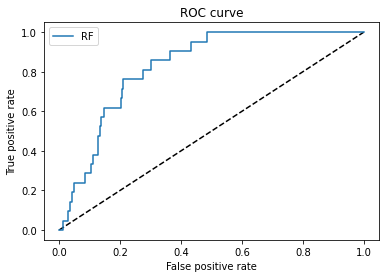

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        47
           1       0.35      1.00      0.52        17

    accuracy                           0.50        64
   macro avg       0.67      0.66      0.50        64
weighted avg       0.83      0.50      0.49        64

Confusion Matrix
[[15 32]
 [ 0 17]]

Accuracy
0.5


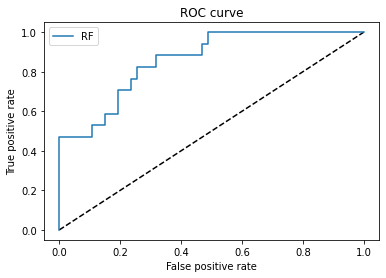

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()